Семинар 7. Сжатие JPEG
----------------------------------------------------
****************************************************

*Материалы:*

[material 1]()

****************************************************

In [1]:
from PIL import Image
import numpy as np
import math

quality = 200

def get_pixels_list_RGB(path):
    
    image = Image.open(path)
    width = image.size[0]
    height = image.size[1]
    
    if image.mode != "RGB":
        image = image.convert("RGB")
    
    image
    
    pixels = image.load()
    
    R = np.zeros((width, height), dtype=int)
    G = np.zeros((width, height), dtype=int)
    B = np.zeros((width, height), dtype=int)
    
    for i in xrange(width):
        for j in xrange(height):
            R[i, j], G[i, j], B[i, j] = pixels[i, j]
            
    return R, G, B
    
R, G, B = get_pixels_list_RGB('cat.bmp')

# Выведем изображение

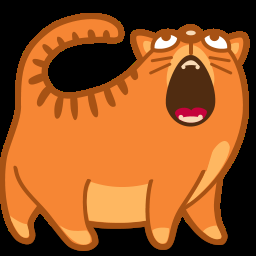

In [2]:
img = Image.new('RGB', (256, 256), 'white')
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (R[i, j], G[i, j], B[i, j])
        
img

# Слой R

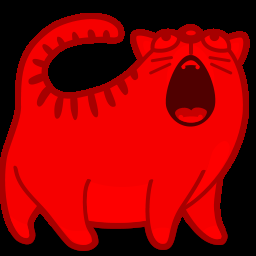

In [3]:
img = Image.new('RGB', (256, 256), 'white')
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (R[i, j], 0, 0)
        
img

# Слой G

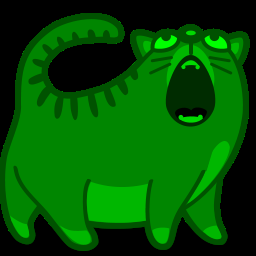

In [4]:
img = Image.new('RGB', (256, 256), 'white')
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (0, G[i, j], 0)
        
img

# Слой B

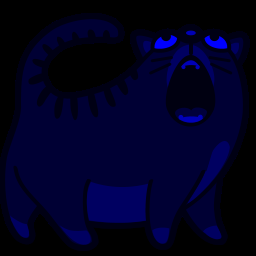

In [5]:
img = Image.new('RGB', (256, 256))
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (0, 0, B[i, j])
        
img

# Переведем в YCrCb

<img src='http://www.compression.ru/book/part2/image31.gif'>

In [6]:
def RGB_to_YCrCb(R, G, B):
    
    width = R.shape[0]
    height = R.shape[1]
    
    Y = np.zeros((width, height), dtype=int)
    Cb = np.zeros((width, height), dtype=int)
    Cr = np.zeros((width, height), dtype=int)
    
    for i in xrange(width):
        for j in xrange(height):
            Y[i, j] = 0.299 * R[i, j] + 0.587 * G[i, j] + 0.114 * B[i, j]
            Cb[i, j] = -0.169 * R[i, j] + -0.331 * G[i, j] + 0.5 * B[i, j] + 128
            Cr[i, j] = 0.5 * R[i, j] + -0.419 * G[i, j] + -0.081 * B[i, j] + 128
            
    return Y, Cr, Cb

Y, Cr, Cb = RGB_to_YCrCb(R, G, B)

# Слой Y

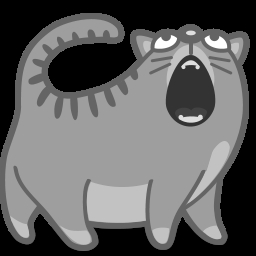

In [7]:
from IPython import display

from io import BytesIO

img = Image.new('YCbCr', (256, 256))
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (Y[i, j], 128, 128)
        
b = BytesIO()
img.save(b, 'JPEG', quality=100)


display.Image(data=b.getvalue(), format='jpg', embed=True)

# Слой Cb

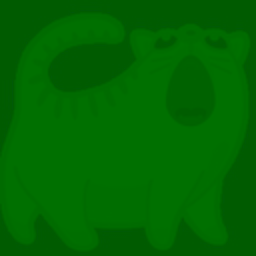

In [8]:
img = Image.new('YCbCr', (256, 256))
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (0, Cb[i, j], 0)
        
b = BytesIO()
img.save(b, 'JPEG', quality=100)


display.Image(data=b.getvalue(), format='jpg', embed=True)

# Слой Cr

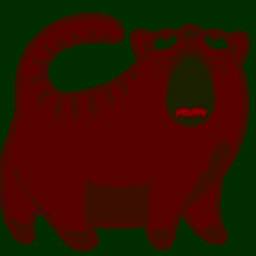

In [9]:
img = Image.new('YCbCr', (256, 256))
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (0, 0, Cr[i, j])
        
b = BytesIO()
img.save(b, 'JPEG', quality=100)


display.Image(data=b.getvalue(), format='jpg', embed=True)

In [10]:
def chroma_sampling():
    # 4:2:0
    
    for x in xrange(Y.shape[0] / 2):
        for y in xrange(Y.shape[1] / 2):
            
            for i in [0, 1]:
                for j in [0, 1]:            
                    Cr[2*x + i, 2*y + j] = Cr[2*x, 2*y]
                    Cb[2*x + i, 2*y + j] = Cb[2*x, 2*y]
                
#chroma_sampling()

# Разобъем на подматрицы 8х8

In [11]:
def divide_to_8(Y, Cr, Cb):
    
    width = Y.shape[0]
    height = Y.shape[1]
    
    width_8_count = width / 8
    height_8_count = height / 8
    
    list_of_Y_8 = []
    list_of_Cr_8 = []
    list_of_Cb_8 = []
    
    for i in xrange(width_8_count):
        for j in xrange(height_8_count):
                        
            Y_8 = Y[8*i: 8*i + 8, 8*j : 8*j + 8].astype(int)
            Cr_8 = Cr[8*i: 8*i + 8, 8*j : 8*j + 8].astype(int)
            Cb_8 = Cb[8*i: 8*i + 8, 8*j : 8*j + 8].astype(int)
                    
            list_of_Y_8.append(Y_8)
            list_of_Cr_8.append(Cr_8)
            list_of_Cb_8.append(Cb_8)
            
    
    return list_of_Y_8, list_of_Cr_8, list_of_Cb_8

list_of_Y_8, list_of_Cr_8, list_of_Cb_8 = divide_to_8(Y, Cr, Cb)

# Воспользуемся дискрентым косинусным преобразованием:

$$DKT(i,\ j) = \frac{1}{\sqrt{2N}}C(i)C(j)\sum_{x=0}^{N-1}\sum_{y=0}^{N-1}f(x,\ y)cos\bigg[\frac{(2x+1)i\pi}{2N}\bigg]cos\bigg[\frac{(2y+1)j\pi}{2N}\bigg]$$

$$f(x,\ y) = \frac {1}{\sqrt{2N}}\sum_{i=0}^{N-1}\sum_{j=0}^{N-1}C(i)C(j)DKT(i,\ j)cos\bigg[\frac{(2x+1)i\pi}{2N}\bigg]cos\bigg[\frac{(2y+1)j\pi}{2N}\bigg]$$

$$C(x) = \begin{cases}
    \frac{1}{\sqrt{2}} & \quad \text{if } x = 0\\
    1                  & \quad \text{if } x > 0\\
  \end{cases}
$$

## Для этого сформируем матрицу специального вида:

$$ C(i,\ j) = \begin{cases}
    \frac{1}{\sqrt{8}}                                         & \quad \text{if } i = 0\\
    \sqrt{\frac{2}{8}}*cos\big[\frac{(2j+1)i\pi}{2N}\big]      & \quad \text{if } i > 0\\
  \end{cases}
$$

## Таким образом, ДКП сводится к применению следующей операции:

$$ X_{DKT} = CXC^{T} $$

In [12]:
def form_C_matrix():    
    result = np.zeros((8, 8))
    for i in xrange(8):
        for j in xrange(8):            
            result[i, j] = 1 / math.sqrt(8) if i == 0 else math.sqrt(2.0/8) * math.cos(((2*j + 1) * math.pi * i) / 16)
    return result

C = form_C_matrix()
    
def DKT_for_8(matrix):
    return np.dot(np.dot(C, matrix), C.T)

list_of_Cr_8_DKT = []
list_of_Cb_8_DKT = []

for element in list_of_Cr_8:
    list_of_Cr_8_DKT.append(DKT_for_8(element))

for element in list_of_Cb_8:
    list_of_Cb_8_DKT.append(DKT_for_8(element))

# Применим квантование (округление)

$$Q[i,\ j] = 1 + (1 + i + j)*q$$

<center>Где q - показатель (фактор) качества</center>

In [13]:
def get_Q_matrix(q):
    result = np.zeros((8, 8), dtype=int) 
    for i in xrange(8):
        for j in xrange(8):            
            result[i, j] = 1 + (1 + i + j) * q
            
    return result

print get_Q_matrix(quality)

[[ 201  401  601  801 1001 1201 1401 1601]
 [ 401  601  801 1001 1201 1401 1601 1801]
 [ 601  801 1001 1201 1401 1601 1801 2001]
 [ 801 1001 1201 1401 1601 1801 2001 2201]
 [1001 1201 1401 1601 1801 2001 2201 2401]
 [1201 1401 1601 1801 2001 2201 2401 2601]
 [1401 1601 1801 2001 2201 2401 2601 2801]
 [1601 1801 2001 2201 2401 2601 2801 3001]]


In [14]:
Q = get_Q_matrix(quality)

list_of_Cr_8_DKT_Q = []
list_of_Cb_8_DKT_Q = []

for element in list_of_Cr_8_DKT:
    list_of_Cr_8_DKT_Q.append((element / Q).astype(int))
    
for element in list_of_Cb_8_DKT:
    list_of_Cb_8_DKT_Q.append((element / Q).astype(int))

# Производим сжатие

<img src='http://rain.ifmo.ru/cat/data/theory/data-compression/jpeg-2006/img/jpeg/zigzag.gif'>

In [15]:
code_matrix = np.array([
    [1, 2, 6, 7, 15, 16, 28, 29],
    [3, 5, 8, 14, 17, 27, 30, 43],
    [4, 9, 13, 18, 26, 31, 42, 44],
    [10, 12, 19, 25, 32, 41, 45, 54],
    [11, 20, 24, 33, 40, 46, 53, 55],
    [21, 23, 34, 39, 47, 52, 56, 61],
    [22, 35, 38, 48, 51, 57, 60, 62],
    [36, 37, 49, 50, 58, 59, 63, 64]
])

print code_matrix

[[ 1  2  6  7 15 16 28 29]
 [ 3  5  8 14 17 27 30 43]
 [ 4  9 13 18 26 31 42 44]
 [10 12 19 25 32 41 45 54]
 [11 20 24 33 40 46 53 55]
 [21 23 34 39 47 52 56 61]
 [22 35 38 48 51 57 60 62]
 [36 37 49 50 58 59 63 64]]


In [16]:
def use_zig_zag(matrix):
    result = []
    for i in xrange(64):
        result.append(matrix[np.where(code_matrix == i + 1)[0][0], np.where(code_matrix == i + 1)[1][0]])
        
    return result

In [17]:
def create_blocks(elements):
    result = []
    zero_count = 0
    current_element = 0
    while 1:
        try:
            if not elements[current_element]:
                zero_count += 1
            else:
                result.append((zero_count, elements[current_element]))
                zero_count = 0
            
            if current_element == 63 and not elements[current_element]:
                result.append((zero_count - 1, elements[current_element]))
                return result
            
            current_element += 1
            continue
            
        except:
            return result

In [18]:
list_of_Cr_8_codes = []
list_of_Cb_8_codes = []

for element in list_of_Cr_8_DKT_Q:
    list_of_Cr_8_codes.append(create_blocks(use_zig_zag(element)))
    
for element in list_of_Cb_8_DKT_Q:
    list_of_Cb_8_codes.append(create_blocks(use_zig_zag(element)))

# Формируем матрицу из списка

In [19]:
def form_matrix(codes):
    i = 0
    result = np.zeros((8, 8), dtype=int)
    while i < 64:
        for element in codes:
            for _ in xrange(element[0]):
                result[np.where(code_matrix == i + 1)[0][0], np.where(code_matrix == i + 1)[1][0]] = 0
                i += 1
            result[np.where(code_matrix == i + 1)[0][0], np.where(code_matrix == i + 1)[1][0]] = element[1]
            i += 1
    return result

In [20]:
list_of_Cr_8_DKT_Q_1 = []
list_of_Cb_8_DKT_Q_1 = []

for element in list_of_Cr_8_codes:
    list_of_Cr_8_DKT_Q_1.append(form_matrix(element))
    
for element in list_of_Cb_8_codes:
    list_of_Cb_8_DKT_Q_1.append(form_matrix(element))

# Производим обратное квантование

In [21]:
list_of_Cr_8_DKT_1 = []
list_of_Cb_8_DKT_1 = []


for element in list_of_Cr_8_DKT_Q_1:
    list_of_Cr_8_DKT_1.append(element * Q)
    
for element in list_of_Cb_8_DKT_Q_1:
    list_of_Cb_8_DKT_1.append(element * Q)

# Производим обратное ДКП

$$f(x,\ y) = \frac {1}{\sqrt{2N}}\sum_{i=0}^{N-1}\sum_{j=0}^{N-1}C(i)C(j)DKT(i,\ j)cos\bigg[\frac{(2x+1)i\pi}{2N}\bigg]cos\bigg[\frac{(2x+1)j\pi}{2N}\bigg]$$

$$C(x) = \begin{cases}
    \frac{1}{\sqrt{2}} & \quad \text{if } x = 0\\
    1                  & \quad \text{if } x > 0\\
  \end{cases}
$$

In [22]:
def DKT_for_8_1(matrix):
    return np.dot(np.dot(C.T, matrix), C)

list_of_Cr_8_1 = []
list_of_Cb_8_1 = []

for element in list_of_Cr_8_DKT_1:
    list_of_Cr_8_1.append((DKT_for_8_1(element).astype(int)))

for element in list_of_Cb_8_DKT_1:
    list_of_Cb_8_1.append((DKT_for_8_1(element).astype(int)))

# Формируем матрицы из подматриц

In [23]:
def form_from_8(list_of_Cr_8_1, list_of_Cb_8_1):
    
    width = 256
    height = 256
    
    width_8_count = width / 8
    height_8_count = height / 8
    
    Cr_1 = np.zeros((256, 256), dtype=int)
    Cb_1 = np.zeros((256, 256), dtype=int)
        
    for i in xrange(width_8_count):
        for j in xrange(height_8_count):
                    
            Cr_1[8*i : 8*i + 8, 8*j : 8*j + 8] = list_of_Cr_8_1[i * width_8_count + j]
            Cb_1[8*i : 8*i + 8, 8*j : 8*j + 8] = list_of_Cb_8_1[i * width_8_count + j]
                    
    return Cr_1, Cb_1

Cr_1, Cb_1 = form_from_8(list_of_Cr_8_1, list_of_Cb_8_1)

# Слой Y (без изменений)

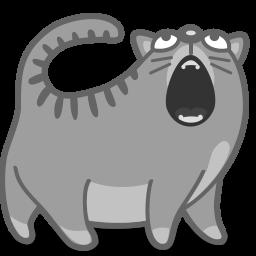

In [24]:
img = Image.new('YCbCr', (256, 256))
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (Y[i, j], 128, 128)
        
b = BytesIO()
img.save(b, 'JPEG')


display.Image(data=b.getvalue(), format='jpg', embed=True)

## Слой Cb

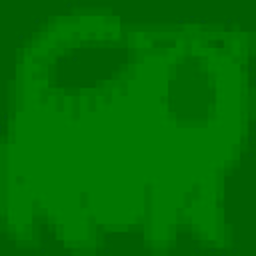

In [25]:
img = Image.new('YCbCr', (256, 256))
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (0, Cb_1[i, j], 0)
        
b = BytesIO()
img.save(b, 'JPEG')


display.Image(data=b.getvalue(), format='jpg', embed=True)

# Слой Cr

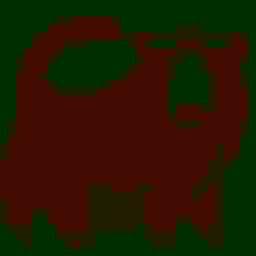

In [26]:
img = Image.new('YCbCr', (256, 256))
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (0, 0, Cr_1[i, j])
        
b = BytesIO()
img.save(b, 'JPEG')


display.Image(data=b.getvalue(), format='jpg', embed=True)

# Результат

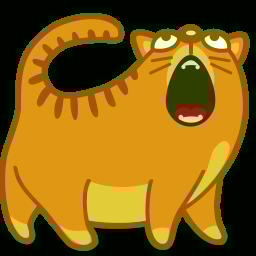

In [30]:
img = Image.new('YCbCr', (256, 256))
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = (Y[i, j], Cb_1[i, j], Cr_1[i, j])
        
b = BytesIO()
img.save(b, 'JPEG')
img.save('result.jpg', 'jpeg')


display.Image(data=b.getvalue(), format='jpg', embed=True)

# Исходное изображение

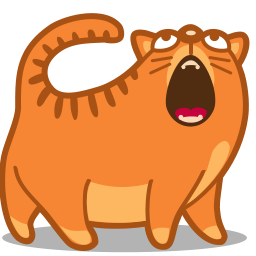

In [29]:
Image.open('cat.bmp')

### Как можно заметить, даже при большом коэффициенте сжатия изображение можно будет почти полностью восстановить (при условии, что канал Y не был подвергнут сжатию)